In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker import FormatStrFormatter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


cm = 1/2.54
plt.rcParams['pdf.fonttype'] = 42

plt.rc('axes', linewidth=1*cm)
sns.set()
sns.set_style("white")
sns.set_context("poster")

sns.set_palette('muted')

In [2]:
PVM_MARKERS = ['Pf4', 'Lyz2', 'Ms4a7', 'Ccl24', 'F13a1', 'Cd74', 'Mrc1']

In [3]:
marker_df = pd.read_csv('./pvm_marker_counts.csv')

In [4]:
pvm_df = pd.read_csv('../topact-data/chen2022-mousebrain/chen2022_adult_mouse_brain_TOPACT_PVM_LOCI.csv.csv')

In [5]:
def saturate_hull(hull, cells, numcells=200):
    
    m,n = hull.shape
    
    hit = hull.copy()
    
    for x,y in cells:
        hit[x-100:x+100,y-100:y+100] = 0
    
    failures = 0
    
    newcells = []
    
    while len(newcells) < numcells:
        
        x = np.random.randint(m)
        y = np.random.randint(n)
        
        if hit[x,y]:
            
            newcells.append((x,y))
            hit[x-100:x+100,y-100:y+100] = 0

    return newcells

In [6]:
def sample_background_cells(mask, num_cells = None):
    pvmsx = np.array(list(pvm_df['centroid-1'])).astype('int')
    pvmsy = np.array(list(pvm_df['centroid-0'])).astype('int')
    pvms = np.vstack([pvmsx, pvmsy]).T
    bgcells = saturate_hull(mask, pvms, num_cells if num_cells else len(pvmsx))
    bgcells = np.array(bgcells)
    return bgcells

In [7]:
def getviolinplotdf(pvms, bgcells):
        
    cellcounts = []

    for y,x in pvms:

        celldf = marker_df[(marker_df.newx  >= x - 50) & 
                           (marker_df.newx < x + 50) & 
                           (marker_df.newy >= y - 50) & 
                           (marker_df.newy < y + 50)
                          ]

        celldf = celldf.groupby('geneID').sum().reset_index()

        localcounts = {marker : 0 for marker in PVM_MARKERS}

        for row in celldf.itertuples():
            localcounts[row.geneID] += row.MIDCounts
        cellcounts.append(localcounts)
        

    bgcellcounts = []

    for y,x in bgcells:

        celldf = marker_df[(marker_df.newx >= x - 50) &
                           (marker_df.newx < x + 50) &
                           (marker_df.newy >= y - 50) &
                           (marker_df.newy < y + 50)
                          ]

        celldf = celldf.groupby('geneID').sum().reset_index()

        localcounts = {marker : 0 for marker in PVM_MARKERS}
        for row in celldf.itertuples():
            localcounts[row.geneID] += row.MIDCounts
        bgcellcounts.append(localcounts)
        
    violindf = pd.DataFrame(cellcounts + bgcellcounts)
    violindf['group'] = ['PVM'] * len(pvms) + ['Background'] * len(bgcells)
    
    # Adding up all the counts
    numeric_columns = violindf.select_dtypes(include=[int])
    row_sums = numeric_columns.sum(axis=1)
    violindf['All markers'] = row_sums
    
    return violindf

In [8]:
# You can sample your own background cells like this:
# mask = np.loadtxt('./chen2022_adult_mouse_brain_CONVEXHULL.txt')
# bgcells = sample_background_cells(mask=mask)

# or use ours:
bgcells = np.loadtxt('background_cells.txt')

In [9]:
pvmsx = np.array(list(pvm_df['centroid-1'])).astype('int')
pvmsy = np.array(list(pvm_df['centroid-0'])).astype('int')
pvms = np.vstack([pvmsx, pvmsy]).T

violindf = getviolinplotdf(pvms, bgcells)

In [10]:
violindf = pd.melt(violindf, id_vars="group", var_name="marker")
violindf['logcount'] = violindf.value.apply(lambda x: np.log(x+1))

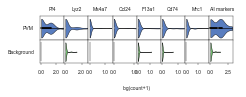

In [11]:
sns.set(style="ticks", context='paper', font="Arial")
plt.rcParams.update({'font.size': 5, 'lines.color': 'black'})

g = sns.FacetGrid(violindf, 
                  row="group", col="marker", hue='group', sharex="col", 
                  margin_titles=True, despine=False, 
                  palette={'Background': (0.41568627450980394, 0.8, 0.39215686274509803), 
                           'PVM': (0.2823529411764706, 0.47058823529411764, 0.8156862745098039)
                          },
                  height=1.1*cm
                 )
g.map(sns.violinplot, "logcount", cut=0, linecolor='black', linewidth=1*cm, inner='box')

plt.subplots_adjust(hspace=0, wspace=0)

g.set_titles(col_template="{col_name}", row_template="", size=5)
g.set_xlabels("")
for ax,l in zip(g.axes[:,0],['PVM', 'Background']):
    ax.set_ylabel(l, rotation=0, ha='right', va='center', fontsize=5)

for ax in g.axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=5, length=2, width=1*cm)
    ax.spines['left'].set_linewidth(1*cm)
    ax.spines['bottom'].set_linewidth(1*cm)
    ax.spines['right'].set_linewidth(1*cm)
    ax.spines['top'].set_linewidth(1*cm)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_yticks([])
    
    
g.axes[1,0].set_xticks([0,2])
g.axes[1,1].set_xticks([0,2])
    
# add a big axis, hide frame
fig=plt.gcf()
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)


plt.xlabel("log(count+1)", fontsize=5)

plt.savefig("./pvmmarkers.pdf", transparent=True, bbox_inches='tight')